# Relative Strengh Index (RSI)
This notebook provides a comprehensive exploration of the Relative Strength Index (RSI), a popular momentum indicator used in technical analysis to measure the speed and change of price movements. Through this analysis, we'll examine how RSI can be calculated, interpreted, and applied to develop trading strategies. Specifically, we will:

Implement the RSI calculation on historical stock data.
Identify potential buy and sell signals based on RSI thresholds.
Backtest an RSI-based trading strategy on Tesla (TSLA) stock data to evaluate its effectiveness.
Visualize the performance and assess the profitability of the RSI strategy.
This notebook aims to offer both a theoretical understanding and practical implementation of RSI, providing insights for using this indicator as part of a trading approach.

## Import Libraries

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from tabulate import tabulate
from datetime import datetime

## Fetch the Data

### Define Stock to Test and Date Range

In [188]:
# Define the stock symbol and the date range for our data
stock_symbol = 'TSLA'
start_date = '2024-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Sets end date to today's date
print(f"RSI Trading for: {stock_symbol}\nStart Date: {start_date}\nEnd Date: {end_date}")

RSI Trading for: TSLA
Start Date: 2024-01-01
End Date: 2024-11-12


### Download and Format Data

In [189]:
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Select the desired columns (first level of MultiIndex)
df.columns = df.columns.get_level_values(0)

# Keep only the columns you are interested in
df = df[['Open', 'Close', 'Volume', 'Low', 'High']]

# If the index already contains the dates, rename the index
df.index.name = 'Date'  # Ensure the index is named "Date"
    
# Resetting the index if necessary
df.reset_index(inplace=True)

# Ensure that the index is of type datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index again (in case it's reset)
df.set_index('Date', inplace=True)

df.head()

[*********************100%***********************]  1 of 1 completed


Price,Open,Close,Volume,Low,High
Date,,,,,
2024-01-02 00:00:00+00:00,250.080002,248.419998,104654200,244.410004,251.250000
2024-01-03 00:00:00+00:00,244.979996,238.449997,121082600,236.320007,245.679993
2024-01-04 00:00:00+00:00,239.250000,237.929993,102629300,237.729996,242.699997
2024-01-05 00:00:00+00:00,236.860001,237.490005,92379400,234.899994,240.119995
2024-01-08 00:00:00+00:00,236.139999,240.449997,85166600,235.300003,241.250000


## Show the Stock Chart

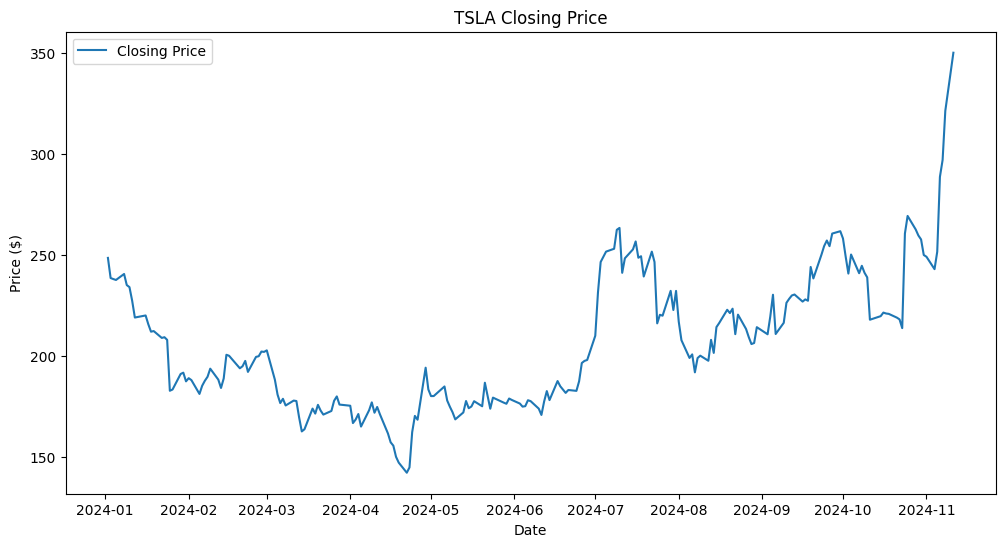

In [190]:
# Plot the closing price
plt.figure(figsize=(12, 6))

plt.plot(df['Close'], label='Closing Price')

# Add title, labels, and legend
plt.title(f'{stock_symbol} Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()

# Save the plot in 300dpi
plt.savefig(f'{stock_symbol}_stock_chart.png', dpi=300)

# Show the plot
plt.show()

## Calculating the Relative Strength Index (RSI)

In [191]:
# Calculate daily returns
df['Change'] = df['Close'].diff()
df['Gain'] = np.where(df['Change'] > 0, df['Change'], 0)
df['Loss'] = np.where(df['Change'] < 0, -df['Change'], 0)

# Calculate the average gain and loss
df['Avg Gain'] = df['Gain'].rolling(window=14).mean()
df['Avg Loss'] = df['Loss'].rolling(window=14).mean()

# Calculate RS and RSI
df['RS'] = df['Avg Gain'] / df['Avg Loss']
df['RSI'] = 100 - (100 / (1 + df['RS']))

# Define a single Signal column
df['Signal'] = np.where(df['RSI'] < 30, 1, np.where(df['RSI'] > 70, -1, 0))

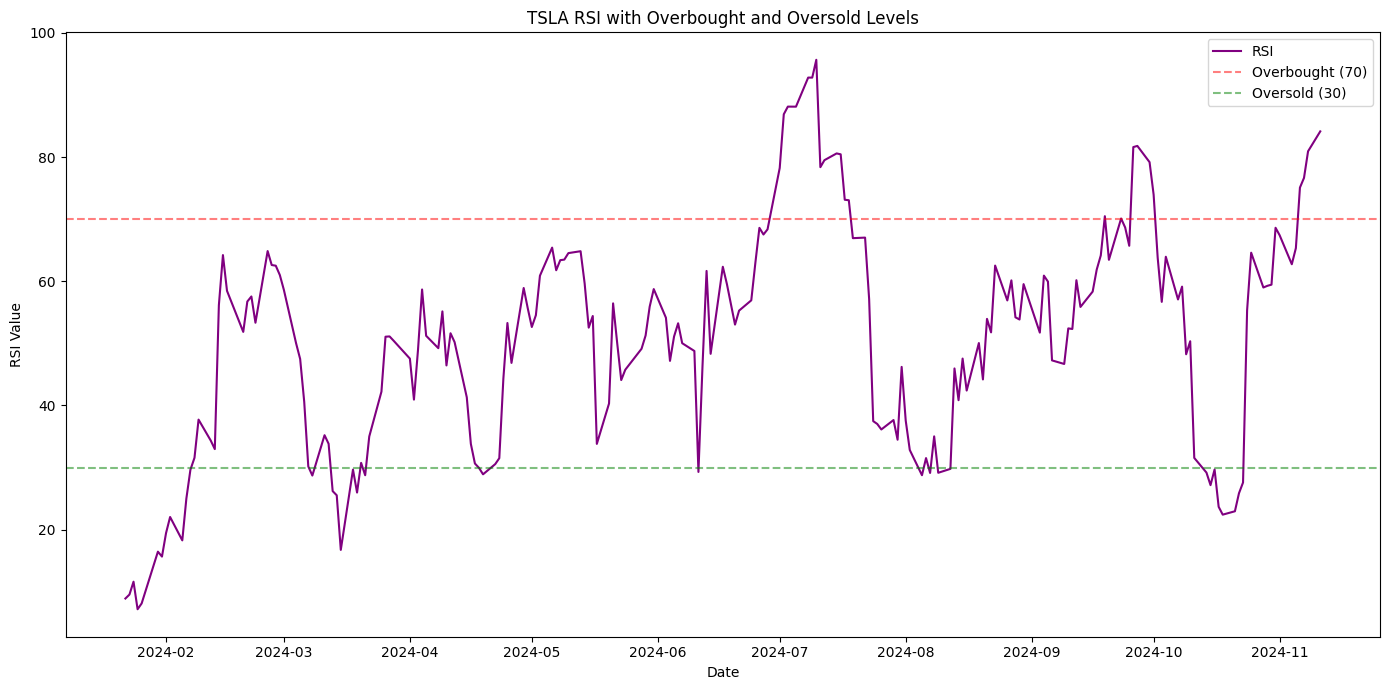

In [192]:
# Plotting RSI Chart
plt.figure(figsize=(14, 7))

# Plot RSI
plt.plot(df.index, df['RSI'], label='RSI', color='purple')

# Add horizontal lines for overbought and oversold levels
plt.axhline(70, linestyle='--', alpha=0.5, color='red', label='Overbought (70)')
plt.axhline(30, linestyle='--', alpha=0.5, color='green', label='Oversold (30)')

# Set labels and title
plt.title(f'{stock_symbol} RSI with Overbought and Oversold Levels')
plt.xlabel('Date')  # Add label for x-axis
plt.ylabel('RSI Value')  # Add label for y-axis

# Add legend
plt.legend()

# Save the figure in 300 dpi
plt.savefig(f'{stock_symbol}_rsi_chart.png', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

## Calculate the Brokerage Fee
In this step, we define a function to calculate the brokerage fee for each transaction. The fee is set to 0.25% of the transaction amount, with a minimum fee of $0.01 to ensure that small transactions still incur a reasonable fee. This helps simulate the costs associated with trading, making the strategy more realistic.

In [193]:
# Define the fee calculation function
def calculate_fee(amount: float) -> float:
    """Calculate the brokerage fee based on transaction amount."""
    fee = amount * 0.0025  # 0.25% of the transaction
    return max(fee, 0.01)   # Minimum fee of $0.01

## Simulate the RSI Strategy

In [194]:
# Initialize tracking variables
initial_cash = 100  # starting capital
cash = initial_cash
shares = 0
df['Portfolio Value'] = 0.0
df['Transaction Fee'] = 0.0  # New column to store the transaction fee
transaction_details = []

# Loop through the DataFrame
for i, row in df.iterrows():
    # Buy condition
    if row['Signal'] == 1 and cash > 0:
        fee = calculate_fee(cash)  # Calculate fee on the cash amount
        net_cash = cash - fee      # Adjust cash after fee
        shares = net_cash / row['Close']  # buy as many shares as possible with net cash
        cash = 0
        df.at[i, 'Signal'] = 'Buy'
        df.at[i, 'Transaction Fee'] = fee
        transaction_details.append([row.name, "Buy", round(row['Close'], 2), round(fee, 2), round(cash + (shares * row['Close']), 2)])
    
    # Sell condition
    elif row['Signal'] == -1 and shares > 0:
        proceeds = shares * row['Close']  # Total proceeds from selling all shares
        fee = calculate_fee(proceeds)     # Calculate fee on the proceeds
        cash = proceeds - fee             # Adjust cash after fee
        shares = 0
        df.at[i, 'Signal'] = 'Sell'
        df.at[i, 'Transaction Fee'] = fee
        transaction_details.append([row.name, "Sell", round(row['Close'], 2), round(fee, 2), round(cash, 2)])

    # Update portfolio value after each transaction
    df.at[i, 'Portfolio Value'] = cash + (shares * row['Close'])

# Summarize results using tabulate
print(tabulate(transaction_details, headers=["Date", "Action", "Price ($)", "Fee ($)", "Portfolio Value ($)"], tablefmt="pretty"))

# Final performance
final_value = cash + (shares * df.iloc[-1]['Close'])
profit = final_value - initial_cash
print(f"\nFinal Portfolio Value: ${final_value:.2f}")
print(f"Total Profit/Loss: ${profit:.2f}")


+---------------------------+--------+-----------+---------+---------------------+
|           Date            | Action | Price ($) | Fee ($) | Portfolio Value ($) |
+---------------------------+--------+-----------+---------+---------------------+
| 2024-01-22 00:00:00+00:00 |  Buy   |   208.8   |  0.25   |        99.75        |
| 2024-07-01 00:00:00+00:00 |  Sell  |  209.86   |  0.25   |       100.01        |
| 2024-08-05 00:00:00+00:00 |  Buy   |  198.88   |  0.25   |        99.76        |
| 2024-09-19 00:00:00+00:00 |  Sell  |  243.92   |  0.31   |       122.04        |
| 2024-10-14 00:00:00+00:00 |  Buy   |  219.16   |  0.31   |       121.74        |
| 2024-11-06 00:00:00+00:00 |  Sell  |  288.53   |   0.4   |       159.87        |
+---------------------------+--------+-----------+---------+---------------------+

Final Portfolio Value: $159.87
Total Profit/Loss: $59.87


C:\Users\Brian\AppData\Local\Temp\ipykernel_18512\3656579298.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Buy' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'Signal'] = 'Buy'


## Visualize Buys and Sells and the RSI plot

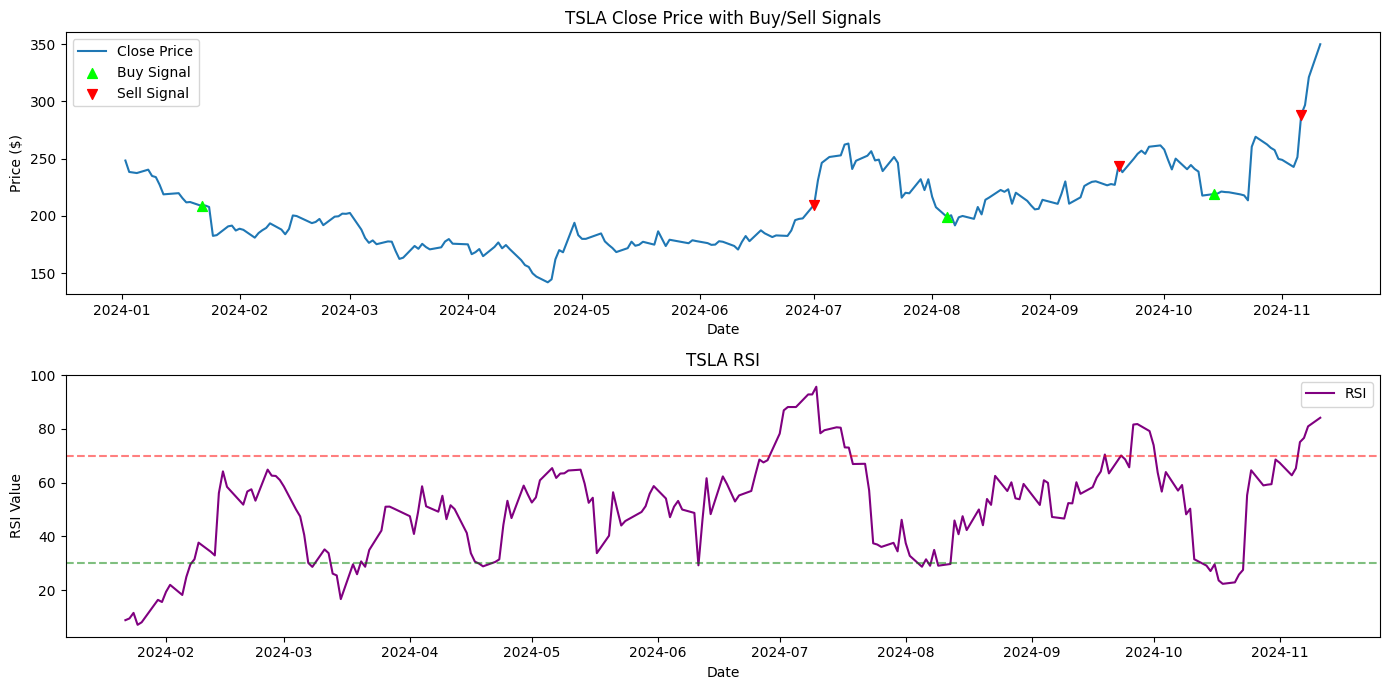

In [195]:
# Plotting
plt.figure(figsize=(14, 7))

# Plot Close Price
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price')
plt.scatter(df[df['Signal'] == 'Buy'].index, df[df['Signal'] == 'Buy']['Close'], marker='^', color='lime', s=50, zorder=5, label='Buy Signal')
plt.scatter(df[df['Signal'] == 'Sell'].index, df[df['Signal'] == 'Sell']['Close'], marker='v', color='red', s=50, zorder=5, label='Sell Signal')
plt.title(f'{stock_symbol} Close Price with Buy/Sell Signals')
plt.xlabel('Date')  # Adding label for x-axis
plt.ylabel('Price ($)')  # Adding label for y-axis
plt.legend()

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(df.index, df['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='green')
plt.title(f'{stock_symbol} RSI')
plt.xlabel('Date')  # Adding label for x-axis
plt.ylabel('RSI Value')  # Adding label for y-axis
plt.legend()
plt.tight_layout()
plt.savefig(f'{stock_symbol}_rsi_trading.png', dpi=300)
plt.show()
